In [1]:
import os
import sys
import argparse

#prj_path = os.path.join(os.path.dirname(__file__), '..')
#if prj_path not in sys.path:
#    sys.path.append(prj_path)

from lib.test.evaluation import get_dataset
from lib.test.evaluation.running import run_dataset
from lib.test.evaluation.tracker import Tracker
from lib.test.evaluation import Sequence, Tracker
from pl_prac import Settings

epsilon_grid = [0.0025, 0.005, 0.01, 0.02, 0.04, 0.08]

#!python tracking/create_default_local_file.py --workspace_dir . --data_dir ./data --save_dir .

from torchviz import make_dot, make_dot_from_trace
import multiprocessing
from collections import OrderedDict
import numpy as np
import time
import torch
from lib.utils.misc import NestedTensor
from lib.train.data.processing_utils import sample_target
from lib.utils.merge import merge_template_search, merge_template_search_odin

https://discuss.pytorch.org/t/why-cant-i-see-grad-of-an-intermediate-variable/94/7

In [2]:
def parse_args(args):
    parser = argparse.ArgumentParser(description='Run tracker on sequence or dataset.')
    parser.add_argument('tracker_name', type=str, help='Name of tracking method.')
    parser.add_argument('tracker_param', type=str, help='Name of config file.')
    parser.add_argument('--runid', type=int, default=None, help='The run id.')
    parser.add_argument('--dataset_name', type=str, default='otb', help='Name of dataset (otb, nfs, uav, tpl, vot, tn, gott, gotv, lasot).')
    parser.add_argument('--sequence', type=str, default=None, help='Sequence number or name.')
    parser.add_argument('--debug', type=int, default=0, help='Debug level.')
    parser.add_argument('--threads', type=int, default=0, help='Number of threads.')
    parser.add_argument('--num_gpus', type=int, default=2)
    parser.add_argument('--run_fn', type=str, default='run_epsilon')
    parser.add_argument('--modelname', type=str, default='exot_st2')
    parser.add_argument('--ckpt_name', type=str, default='EXOTST_epoch=49.pth.tar')
    parser.add_argument('--epsilon', type=float, default=0.005)
    parser.add_argument('--version', type=str, default='cos')

    args = parser.parse_args(args)

    try:
        seq_name = int(args.sequence)
    except:
        seq_name = args.sequence

    return args, seq_name
    run_tracker(args.tracker_name, args.tracker_param, args.run_fn, args.epsilon, args.version, args.modelname,
                args.ckpt_name, args.runid, args.dataset_name, seq_name, args.debug,
                args.threads, num_gpus=args.num_gpus)

In [17]:
args, seq_name = parse_args(["exotst_tracker", "baseline_mix_lowdim", "--dataset", "trek150_test", "--run_fn", "run_epsilon",
 '--modelname', 'exot_st2', '--ckpt_name', 'baseline_mix_lowdim/EXOTST_ep0069.pth.tar', '--epsilon', '0.00125', '--threads', '0',
  '--version', 'h', '--num_gpus', "1", "--debug", "1"])
dataset = get_dataset(args.dataset_name)

if seq_name is not None:
    dataset = [dataset[seq_name]]

trackers = [Tracker(args.tracker_name, args.tracker_param, args.dataset_name, args.modelname, args.ckpt_name, args.runid)]

multiprocessing.set_start_method('spawn', force=True)

print('Evaluating {:4d} trackers on {:5d} sequences'.format(len(trackers), len(dataset)))

multiprocessing.set_start_method('spawn', force=True)

seq = dataset[0]
tracker = trackers[0]
num_gpu = 1
debug = args.debug
version = args.version

try:
    worker_name = multiprocessing.current_process().name
    worker_id = int(worker_name[worker_name.find('-') + 1:]) - 1
    gpu_id = worker_id % num_gpu
    #torch.cuda.set_device(gpu_id)
except:
    pass

print('Tracker: {} {} {} ,  Sequence: {}'.format(tracker.name, tracker.parameter_name, tracker.run_id, seq.name))

mean_scores = {}

epsilon = epsilon_grid[0]
params = tracker.get_parameters()

debug_ = debug
if debug is None:
    debug_ = getattr(params, 'debug', 0)

params.debug = debug_

# Get init information
init_info = seq.init_info()
dataset_mean = []

exot_tracker = tracker.create_tracker(params)
#output = _track_epsilon(tracker, exot_tracker, seq, epsilon, version, init_info)
#def _track_epsilon(self_track, tracker, seq, epsilon, version, init_info):
output = {'target_bbox': [],
        'time': [], 
        'odin_meanscore': []}
if exot_tracker.params.save_all_boxes:
    output['all_boxes'] = []
    output['all_scores'] = []

def _store_outputs(tracker_out: dict, defaults=None):
    defaults = {} if defaults is None else defaults
    for key in output.keys():
        val = tracker_out.get(key, defaults.get(key, None))
        if key in tracker_out or val is not None:
            output[key].append(val)

# Initialize
image = tracker._read_image(seq.frames[0])

start_time = time.time()
out = exot_tracker.initialize(image, init_info)
if out is None:
    out = {}

prev_output = OrderedDict(out)
init_default = {'target_bbox': init_info.get('init_bbox'),
                'time': time.time() - start_time}
if exot_tracker.params.save_all_boxes:
    init_default['all_boxes'] = out['all_boxes']
    init_default['all_scores'] = out['all_scores']

_store_outputs(out, init_default)

#for frame_num, frame_path in enumerate(seq.frames[1:], start=1):
frame_num = 1
frame_path = seq.frames[1]
image = tracker._read_image(frame_path)

start_time = time.time()

info = seq.frame_info(frame_num)
info['previous_output'] = prev_output

#def odin_new_track(self, image, epsilon, version, info: dict = None):
H, W, _ = image.shape
exot_tracker.frame_id += 1
# get the t-th search region        
x_patch_arr, resize_factor, x_amask_arr = sample_target(image, exot_tracker.state, exot_tracker.params.search_factor,
                                                        output_sz=exot_tracker.params.search_size)  # (x1, y1, w, h)
search_grad, search_mask = exot_tracker.preprocessor_odin.process(x_patch_arr, x_amask_arr)
'''
[W accumulate_grad.h:185] Warning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [256, 1024, 1, 1], strides() = [1024, 1, 1, 1]
param.sizes() = [256, 1024, 1, 1], strides() = [1024, 1, 1024, 1024] (function operator())
'''
#search_grad =search_grad.requires_grad_()
search = NestedTensor(search_grad, search_mask)

# with torch.no_grad():
x_dict = exot_tracker.network.forward_backbone(search)
for n,p in exot_tracker.network.backbone.named_parameters():
    print(n, p)

/home/ella/projects/mfmot/STARK/data/TREK-150
Evaluating    1 trackers on    14 sequences
Tracker: exotst_tracker baseline_mix_lowdim None ,  Sequence: P03-P03_04-406
test config:  {'MODEL': {'HEAD_TYPE': 'CORNER', 'NLAYER_HEAD': 3, 'HEAD_ABS': 'backbone', 'ODIN_TYPE': 'ori', 'HIDDEN_DIM': 256, 'NUM_OBJECT_QUERIES': 1, 'POSITION_EMBEDDING': 'sine', 'PREDICT_MASK': False, 'LOSS_TYPE': 'None', 'BACKBONE': {'TYPE': 'resnet50', 'OUTPUT_LAYERS': ['layer3'], 'STRIDE': 16, 'DILATION': False}, 'TRANSFORMER': {'NHEADS': 8, 'DROPOUT': 0.1, 'DIM_FEEDFORWARD': 2048, 'ENC_LAYERS': 6, 'DEC_LAYERS': 6, 'PRE_NORM': False, 'DIVIDE_NORM': False}}, 'TRAIN': {'TRAIN_CLS': True, 'LR': 0.0001, 'WEIGHT_DECAY': 0.0001, 'EPOCH': 100, 'LR_DROP_EPOCH': 90, 'BATCH_SIZE': 16, 'NUM_WORKER': 8, 'OPTIMIZER': ['ADAMW', 'SGD'], 'BACKBONE_MULTIPLIER': 0.1, 'REID_WEIGHT': 3.0, 'EXIT_WEIGHT': 3.0, 'GIOU_WEIGHT': 2.0, 'L1_WEIGHT': 5.0, 'CLS_WEIGHT': 1.0, 'OBJCLS_WEIGHT': 0.2, 'DEEP_SUPERVISION': False, 'FREEZE_BACKBONE_BN'

In [15]:




# make_dot(x_dict['feat'], params = dict(exot_tracker.network.backbone.named_parameters()))


None tensor([[[[ 1.3335e-02,  1.4664e-02, -1.5351e-02,  ..., -4.0896e-02,
           -4.3034e-02, -7.0755e-02],
          [ 4.1205e-03,  5.8477e-03,  1.4948e-02,  ...,  2.2060e-03,
           -2.0912e-02, -3.8517e-02],
          [ 2.2331e-02,  2.3595e-02,  1.6120e-02,  ...,  1.0281e-01,
            6.2641e-02,  5.1977e-02],
          ...,
          [-9.0349e-04,  2.7767e-02, -1.0105e-02,  ..., -1.2722e-01,
           -7.6604e-02,  7.8453e-03],
          [ 3.5894e-03,  4.8006e-02,  6.2051e-02,  ...,  2.4267e-02,
           -3.3662e-02, -1.5709e-02],
          [-8.0029e-02, -3.2238e-02, -1.7808e-02,  ...,  3.5359e-02,
            2.2439e-02,  1.7077e-03]],

         [[-1.8452e-02,  1.1415e-02,  2.3850e-02,  ...,  5.3736e-02,
            4.4022e-02, -9.4675e-03],
          [-7.7273e-03,  1.8890e-02,  6.7981e-02,  ...,  1.5956e-01,
            1.4606e-01,  1.1999e-01],
          [-4.6013e-02, -7.6075e-02, -8.9648e-02,  ...,  1.2108e-01,
            1.6705e-01,  1.7619e-01],
          ...,


In [5]:
args, seq_name = parse_args(["stark_st", "baseline_mix", "--dataset", "trek150_test", "--run_fn", "run_seq",
 '--modelname', 'stark_st2', '--ckpt_name', 'baseline_mix/STARKST_epoch=49-v1.pth.tar', '--epsilon', '0.00125', '--threads', '0',
  '--version', 'h', '--num_gpus', "1", "--debug", "1"])
dataset = get_dataset(args.dataset_name)

if seq_name is not None:
    dataset = [dataset[seq_name]]

trackers = [Tracker(args.tracker_name, args.tracker_param, args.dataset_name, args.modelname, args.ckpt_name, args.runid)]

multiprocessing.set_start_method('spawn', force=True)

print('Evaluating {:4d} trackers on {:5d} sequences'.format(len(trackers), len(dataset)))

multiprocessing.set_start_method('spawn', force=True)

seq = dataset[0]
tracker = trackers[0]

num_gpu = 1
debug = args.debug
version = args.version

try:
    worker_name = multiprocessing.current_process().name
    worker_id = int(worker_name[worker_name.find('-') + 1:]) - 1
    gpu_id = worker_id % num_gpu
    #torch.cuda.set_device(gpu_id)
except:
    pass

print('Tracker: {} {} {} ,  Sequence: {}'.format(tracker.name, tracker.parameter_name, tracker.run_id, seq.name))

mean_scores = {}

epsilon = epsilon_grid[0]
params = tracker.get_parameters()

debug_ = debug
if debug is None:
    debug_ = getattr(params, 'debug', 0)

params.debug = debug_

# Get init information
init_info = seq.init_info()
dataset_mean = []

exot_tracker = tracker.create_tracker(params)

output = {'target_bbox': [],
        'time': [], 
        'odin_meanscore': []}
if exot_tracker.params.save_all_boxes:
    output['all_boxes'] = []
    output['all_scores'] = []

def _store_outputs(tracker_out: dict, defaults=None):
    defaults = {} if defaults is None else defaults
    for key in output.keys():
        val = tracker_out.get(key, defaults.get(key, None))
        if key in tracker_out or val is not None:
            output[key].append(val)

# Initialize
image = tracker._read_image(seq.frames[0])

start_time = time.time()
out = exot_tracker.initialize(image, init_info)
if out is None:
    out = {}

prev_output = OrderedDict(out)
init_default = {'target_bbox': init_info.get('init_bbox'),
                'time': time.time() - start_time}
if exot_tracker.params.save_all_boxes:
    init_default['all_boxes'] = out['all_boxes']
    init_default['all_scores'] = out['all_scores']

_store_outputs(out, init_default)

#for frame_num, frame_path in enumerate(seq.frames[1:], start=1):
frame_num = 1
frame_path = seq.frames[1]
image = tracker._read_image(frame_path)

start_time = time.time()

info = seq.frame_info(frame_num)
info['previous_output'] = prev_output

H, W, _ = image.shape
exot_tracker.frame_id += 1
# get the t-th search region        
x_patch_arr, resize_factor, x_amask_arr = sample_target(image, exot_tracker.state, exot_tracker.params.search_factor,
                                                        output_sz=exot_tracker.params.search_size)  # (x1, y1, w, h)
search = exot_tracker.preprocessor.process(x_patch_arr, x_amask_arr)

# with torch.no_grad():
for n,p in exot_tracker.network.backbone.named_parameters():
    print(n, p)

/home/ella/projects/mfmot/STARK/data/TREK-150
Evaluating    1 trackers on    14 sequences
Tracker: stark_st baseline_mix None ,  Sequence: P03-P03_04-406
test config:  {'MODEL': {'HEAD_TYPE': 'CORNER', 'NLAYER_HEAD': 3, 'HIDDEN_DIM': 256, 'NUM_OBJECT_QUERIES': 1, 'POSITION_EMBEDDING': 'sine', 'PREDICT_MASK': False, 'LOSS_TYPE': 'None', 'BACKBONE': {'TYPE': 'resnet50', 'OUTPUT_LAYERS': ['layer3'], 'STRIDE': 16, 'DILATION': False}, 'TRANSFORMER': {'NHEADS': 8, 'DROPOUT': 0.1, 'DIM_FEEDFORWARD': 2048, 'ENC_LAYERS': 6, 'DEC_LAYERS': 6, 'PRE_NORM': False, 'DIVIDE_NORM': False}}, 'TRAIN': {'TRAIN_CLS': True, 'LR': 0.0001, 'WEIGHT_DECAY': 0.0001, 'EPOCH': 50, 'LR_DROP_EPOCH': 40, 'BATCH_SIZE': 16, 'NUM_WORKER': 8, 'OPTIMIZER': 'SGD', 'BACKBONE_MULTIPLIER': 0.1, 'GIOU_WEIGHT': 2.0, 'L1_WEIGHT': 5.0, 'CLS_WEIGHT': 1.0, 'OBJCLS_WEIGHT': 0.2, 'DEEP_SUPERVISION': False, 'FREEZE_BACKBONE_BN': True, 'FREEZE_LAYERS': ['conv1', 'layer1'], 'PRINT_INTERVAL': 10, 'VAL_EPOCH_INTERVAL': 10, 'GRAD_CLIP_NORM

/home/ella/projects/mfmot/STARK/lib/models/stark/position_encoding.py:40: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


In [6]:
args, seq_name = parse_args(["stark_st", "baseline_mix", "--dataset", "trek150_test", "--run_fn", "run_seq",
 '--modelname', 'stark_st1', '--ckpt_name', 'baseline_mix_fold_0_5/STARKST_epoch=99.pth.tar', '--epsilon', '0.00125', '--threads', '0',
  '--version', 'h', '--num_gpus', "1", "--debug", "1"])
dataset = get_dataset(args.dataset_name)

if seq_name is not None:
    dataset = [dataset[seq_name]]

trackers = [Tracker(args.tracker_name, args.tracker_param, args.dataset_name, args.modelname, args.ckpt_name, args.runid)]

multiprocessing.set_start_method('spawn', force=True)

print('Evaluating {:4d} trackers on {:5d} sequences'.format(len(trackers), len(dataset)))

multiprocessing.set_start_method('spawn', force=True)

seq = dataset[0]
tracker = trackers[0]

num_gpu = 1
debug = args.debug
version = args.version

try:
    worker_name = multiprocessing.current_process().name
    worker_id = int(worker_name[worker_name.find('-') + 1:]) - 1
    gpu_id = worker_id % num_gpu
    #torch.cuda.set_device(gpu_id)
except:
    pass

print('Tracker: {} {} {} ,  Sequence: {}'.format(tracker.name, tracker.parameter_name, tracker.run_id, seq.name))

mean_scores = {}

epsilon = epsilon_grid[0]
params = tracker.get_parameters()

debug_ = debug
if debug is None:
    debug_ = getattr(params, 'debug', 0)

params.debug = debug_

# Get init information
init_info = seq.init_info()
dataset_mean = []

exot_tracker = tracker.create_tracker(params)

output = {'target_bbox': [],
        'time': [], 
        'odin_meanscore': []}
if exot_tracker.params.save_all_boxes:
    output['all_boxes'] = []
    output['all_scores'] = []

def _store_outputs(tracker_out: dict, defaults=None):
    defaults = {} if defaults is None else defaults
    for key in output.keys():
        val = tracker_out.get(key, defaults.get(key, None))
        if key in tracker_out or val is not None:
            output[key].append(val)

# Initialize
image = tracker._read_image(seq.frames[0])

start_time = time.time()
out = exot_tracker.initialize(image, init_info)
if out is None:
    out = {}

prev_output = OrderedDict(out)
init_default = {'target_bbox': init_info.get('init_bbox'),
                'time': time.time() - start_time}
if exot_tracker.params.save_all_boxes:
    init_default['all_boxes'] = out['all_boxes']
    init_default['all_scores'] = out['all_scores']

_store_outputs(out, init_default)

#for frame_num, frame_path in enumerate(seq.frames[1:], start=1):
frame_num = 1
frame_path = seq.frames[1]
image = tracker._read_image(frame_path)

start_time = time.time()

info = seq.frame_info(frame_num)
info['previous_output'] = prev_output

H, W, _ = image.shape
exot_tracker.frame_id += 1
# get the t-th search region        
x_patch_arr, resize_factor, x_amask_arr = sample_target(image, exot_tracker.state, exot_tracker.params.search_factor,
                                                        output_sz=exot_tracker.params.search_size)  # (x1, y1, w, h)
search = exot_tracker.preprocessor.process(x_patch_arr, x_amask_arr)

# with torch.no_grad():
for n,p in exot_tracker.network.backbone.named_parameters():
    print(n, p)

/home/ella/projects/mfmot/STARK/data/TREK-150
Evaluating    1 trackers on    14 sequences
Tracker: stark_st baseline_mix None ,  Sequence: P03-P03_04-406
test config:  {'MODEL': {'HEAD_TYPE': 'CORNER', 'NLAYER_HEAD': 3, 'HIDDEN_DIM': 256, 'NUM_OBJECT_QUERIES': 1, 'POSITION_EMBEDDING': 'sine', 'PREDICT_MASK': False, 'LOSS_TYPE': 'None', 'BACKBONE': {'TYPE': 'resnet50', 'OUTPUT_LAYERS': ['layer3'], 'STRIDE': 16, 'DILATION': False}, 'TRANSFORMER': {'NHEADS': 8, 'DROPOUT': 0.1, 'DIM_FEEDFORWARD': 2048, 'ENC_LAYERS': 6, 'DEC_LAYERS': 6, 'PRE_NORM': False, 'DIVIDE_NORM': False}}, 'TRAIN': {'TRAIN_CLS': True, 'LR': 0.0001, 'WEIGHT_DECAY': 0.0001, 'EPOCH': 500, 'LR_DROP_EPOCH': 400, 'BATCH_SIZE': 16, 'NUM_WORKER': 8, 'OPTIMIZER': 'ADAMW', 'BACKBONE_MULTIPLIER': 0.1, 'GIOU_WEIGHT': 2.0, 'L1_WEIGHT': 5.0, 'CLS_WEIGHT': 1.0, 'OBJCLS_WEIGHT': 0.2, 'DEEP_SUPERVISION': False, 'FREEZE_BACKBONE_BN': True, 'FREEZE_LAYERS': ['conv1', 'layer1'], 'PRINT_INTERVAL': 50, 'VAL_EPOCH_INTERVAL': 5, 'GRAD_CLIP_N

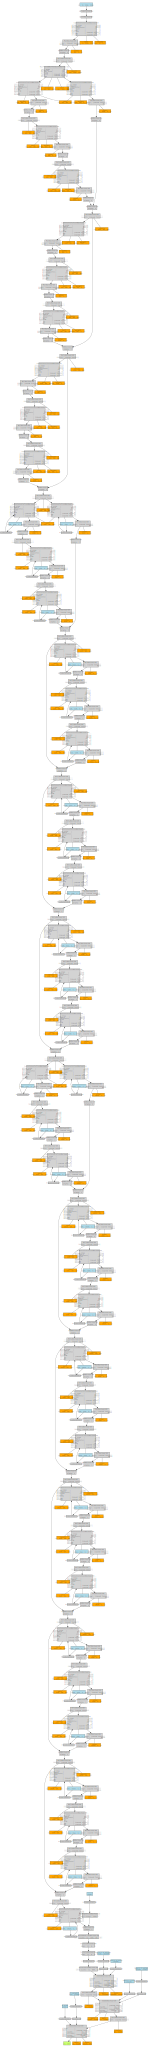

In [14]:

# merge the template and the search
feat_dict_list = exot_tracker.z_dict_list + [x_dict]
seq_dict = merge_template_search_odin(feat_dict_list, return_search=True, return_template=True)

# run the transformer
out_dict, batch_feat_ori, hs, enc_mem = exot_tracker.network.forward_transformer(seq_dict=seq_dict, run_box_head=True, run_cls_head=True)

graph_dict = dict(exot_tracker.network.transformer.named_parameters())
#graph_dict.update(dict(exot_tracker.network.box_head.named_parameters()))
#graph_dict.update(dict(exot_tracker.network.cls_head.named_parameters()))
graph_dict.update(dict(exot_tracker.network.odin_cls.named_parameters()))
# make_dot(out_dict['pred_h'], params = graph_dict, show_attrs=True, show_saved=True)
for param in exot_tracker.network.backbone.parameters():
    print(param.name, param.data)


In [ ]:
# get the final result
pred_boxes = out_dict['pred_boxes'].view(-1, 4)
# Baseline: Take the mean of all pred boxes as the final result
pred_box = (pred_boxes.mean(dim=0) * exot_tracker.params.search_size / resize_factor).tolist()  # (cx, cy, w, h) [0,1]       

###################################
### ODIN ###
###################################
# ODIN 
# print(search_grad.shape) (1,3,320,320)
feat_len_s = 400

if exot_tracker.abs == 'backbone':
    # images_grad = search_grad.requires_grad_()
    tmp = seq_dict['feat_x'].permute((1, 0, 2))
    images_grad = tmp.requires_grad_()           
elif exot_tracker.abs == 'enc_feat':
    batch_feat = enc_mem[-feat_len_s:].transpose(0, 1)  # encoder output for the search region (B, HW, C)
    images_grad = batch_feat.requires_grad_()
elif exot_tracker.abs == 'sim_feat':
    enc_opt = enc_mem[-feat_len_s:].transpose(0, 1)
    dec_opt = hs.squeeze(0).transpose(1, 2)  # (B, C, N)
    att = torch.matmul(enc_opt, dec_opt)  # (B, HW, N)
    opt = (enc_opt.unsqueeze(-1) * att.unsqueeze(-2)) #.permute((0, 3, 2, 1)).contiguous()  # (B, HW, C, N) --> (B, N, C, HW)
    batch_feat = torch.nn.functional.normalize(torch.squeeze(opt, -1), p=1.0)
    images_grad = batch_feat.requires_grad_()
elif exot_tracker.abs == 'hs':
    tmp = torch.squeeze(batch_feat_ori)
    images_grad = tmp.requires_grad_()
print(images_grad)
    #images_grad = batch_feat.requires_grad_()

if version == 'ori':
    odin_logits = out_dict['pred_obj'].requires_grad_()
elif version == 'h':
    odin_logits = out_dict['pred_h'].requires_grad_()
elif version == 'g':
    odin_logits = out_dict['pred_g'].requires_grad_()   
# print(odin_logits.shape, "ODIN") #torch.Size([400, 1, #cls]) ODIN
# images_grad = search_grad.requires_grad_()   
# print(images_grad) 
# if len(odin_logits.shape) >2:
# print(odin_logits.shape, "FIRST") # 1, 1, 1, #cls
odin_logits = torch.squeeze(odin_logits, dim=1)
# print(odin_logits.shape, "LOGITS") # 1, #cls
if version == 'ori' or version=='h':
    odin_loss = torch.amax(odin_logits, dim=1)
else:
    odin_loss = odin_logits
# print("ODIN loss shpae", odin_loss.shape) 1, 1
# odin_loss = - odin_loss
odin_loss = -torch.mean(odin_loss, 0, keepdim=True)
# print(odin_loss, odin_loss.shape) # 1, 1

odin_loss.backward()

# Calculate the gradients of the scores with respect to the inputs.
with torch.no_grad():
    print(images_grad.grad)
    gradient = torch.ge(images_grad.grad, 0)
    gradient = (gradient.float() - 0.5) *2
    gradient[::, 0] = (gradient[::, 0] )/exot_tracker.cfg.DATA.STD[0]
    gradient[::, 1] = (gradient[::, 1] )/exot_tracker.cfg.DATA.STD[1]
    gradient[::, 2] = (gradient[::, 2] )/exot_tracker.cfg.DATA.STD[2]

# Perturb the inputs and derive new mean score.
# test_ds_var.assign_add(epsilon * gradients)
# static_tensor = torch.as_tensor(images)
static_tensor = images_grad.data - epsilon * gradient
#static_tensor = torch.clamp(static_tensor, 0., 255.)


out_dict, _, _, _ = exot_tracker.network.forward_transformer(seq_dict=seq_dict, run_box_head=True, run_cls_head=True, batch_feat=static_tensor)
if version == 'ori':
    new_scores = out_dict['pred_obj']#.sigmoid()
elif version == 'h':
    new_scores = out_dict['pred_h']  # .sigmoid()
elif version == 'g':
    new_scores = out_dict['pred_g']  # .sigmoid()
new_scores = -torch.amax(new_scores, dim=1)
meanscore = torch.mean(new_scores).cpu().numpy() 
#new_mean_score = self.perturb_images(search_grad, search_mask, out_dict, epsilon)
